In [1]:
!pip install mlflow --quiet
!pip install pyngrok --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.5/189.5 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.7/698.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import json
import os
from getpass import getpass

import keras
import librosa
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import numpy as np
from google.colab import drive
from pyngrok import ngrok
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries

# Load MLFLOW from drive

In [4]:
!cp -r /content/drive/MyDrive/GTZAN/mlflow/mlruns .
!ls /content/mlruns -a
!rm -rf /content/mlruns/.ipynb_checkpoints/

.   0			683428462651664209  models
..  637757938191929993	.ipynb_checkpoints  .trash


# View logs using MLFlow

In [5]:
# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = getpass('Enter the ngrok authtoken: ')
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

Enter the ngrok authtoken: ··········


MLflow Tracking UI: https://e1eb-107-178-208-58.ngrok-free.app


In [ ]:
!mlflow ui

# Importing data

In [ ]:
!gdown https://drive.google.com/uc?id=1P12YAYLOg8T7x7beOkHozaPFsBRTFz5w
!unzip GTZAN\ Dataset\ -\ Music\ Genre\ Classification.zip

In [ ]:
mlflow.set_experiment('GTZAN_CNN')

#### Extract the Feature of audio i.e MFCCs and append the data in the dictionary which contain the type of music, MFCCs and the label for the type of music

In [ ]:
SAMPLE_RATE = 22050
DURATION = 30  # 30SEC
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

In [ ]:
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": []
    }

    for i, (dirpath, dirname, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath is not dataset_path:
            dirpath_components = dirpath.split('/')
            semantic_label = dirpath_components[-1]
            data["mapping"].append(semantic_label)
            print(f"\n Processing {semantic_label}")

            num_samples_per_segent = int(SAMPLES_PER_TRACK / num_segments)
            expected_num_mfcc_vectos_per_segment = np.ceil((num_samples_per_segent / hop_length))

            for f in filenames:
                file_path = os.path.join(dirpath, f)
                signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                for s in range(num_segments):
                    start_sample = num_samples_per_segent * s
                    finish_sample = start_sample + num_samples_per_segent

                    mfcc = librosa.feature.mfcc(y=signal[start_sample:finish_sample],
                                                sr=sr,
                                                n_fft=n_fft,
                                                n_mfcc=n_mfcc,
                                                hop_length=hop_length

                                                )
                    mfcc = mfcc.T

                    if len(mfcc) == expected_num_mfcc_vectos_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i - 1)
    return data

In [ ]:
DATASET_PATH = "/content/Data/genres_original"
JSON_PATH = "data.json"
data = save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)


 Processing country

 Processing classical

 Processing metal

 Processing reggae

 Processing jazz

 Processing pop

 Processing hiphop

 Processing rock

 Processing blues

 Processing disco


In [ ]:
JSON_PATH = "data.json"
with open(JSON_PATH, "w") as fp:
    json.dump(data, fp, indent=4)

In [7]:
def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    print("Data succesfully loaded!")

    return X, y

In [8]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.tight_layout()
    plt.show()

# Dataset split for train, test, and validation.

In [9]:
def prepare_dataset(test_size, validation_size):
    # load data
    X, y = load_data("/content/drive/MyDrive/GTZAN/data.json")

    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=42,
    )

    # create train/validation split

    X_train, X_validation, y_train, y_validation = train_test_split(
        X_train,
        y_train,
        test_size=validation_size,
        random_state=42,
    )

    # 3d array
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

# Build CNN model

In [10]:
def build_cnn_model(input_shape):
    """Generates CNN model

    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model

In [11]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_dataset(.20, .2,)

Data succesfully loaded!


In [12]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
cnn_model = build_cnn_model(input_shape)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 6, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                                        

In [13]:
def eval_metrics(y_test, predict_test):
    cm = confusion_matrix(y_test, predict_test)
    accuracy = accuracy_score(y_test, predict_test)

    return cm, accuracy

In [14]:
def train_model(lr):
    with mlflow.start_run():
        optimizer = keras.optimizers.Adam(learning_rate=lr)
        cnn_model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        history = cnn_model.fit(
            X_train,
            y_train,
            batch_size=32,
            validation_data=(X_validation, y_validation),
            epochs=30
        )
        predict_test = cnn_model.predict(X_test)
        prediction_index = np.argmax(predict_test, axis=1)

        cm, accuracy = eval_metrics(y_test, prediction_index)

        print(f"\nconfusion matrix: \n{cm} \n accuracy:{accuracy}")

        mlflow.log_param('learning_rate', lr)
        mlflow.log_param('batch_size', 32)
        mlflow.log_metric('accuracy_score', accuracy)

        mlflow.sklearn.log_model(lr, "cnn_model")

    return history, cnn_model

In [15]:
history, model = train_model(.000327)

Epoch 1/30
200/200 [==============================] - 20s 93ms/step - loss: 2.0282 - accuracy: 0.3250 - val_loss: 1.5645 - val_accuracy: 0.4574
Epoch 2/30
200/200 [==============================] - 17s 85ms/step - loss: 1.5021 - accuracy: 0.4621 - val_loss: 1.2757 - val_accuracy: 0.5538
Epoch 3/30
200/200 [==============================] - 16s 78ms/step - loss: 1.3052 - accuracy: 0.5308 - val_loss: 1.1222 - val_accuracy: 0.6114
Epoch 4/30
200/200 [==============================] - 16s 80ms/step - loss: 1.2007 - accuracy: 0.5767 - val_loss: 1.1072 - val_accuracy: 0.6039
Epoch 5/30
200/200 [==============================] - 18s 90ms/step - loss: 1.0878 - accuracy: 0.6131 - val_loss: 0.9790 - val_accuracy: 0.6615
Epoch 6/30
200/200 [==============================] - 20s 98ms/step - loss: 0.9923 - accuracy: 0.6582 - val_loss: 0.9861 - val_accuracy: 0.6483
Epoch 7/30
200/200 [==============================] - 18s 90ms/step - loss: 0.9260 - accuracy: 0.6739 - val_loss: 0.9364 - val_accuracy:

2023/09/14 11:12:50 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


# store log to drive

In [16]:
!cp -r /content/mlruns/ /content/drive/MyDrive/GTZAN/mlflow

# Plot the train, test accuracy loss graph

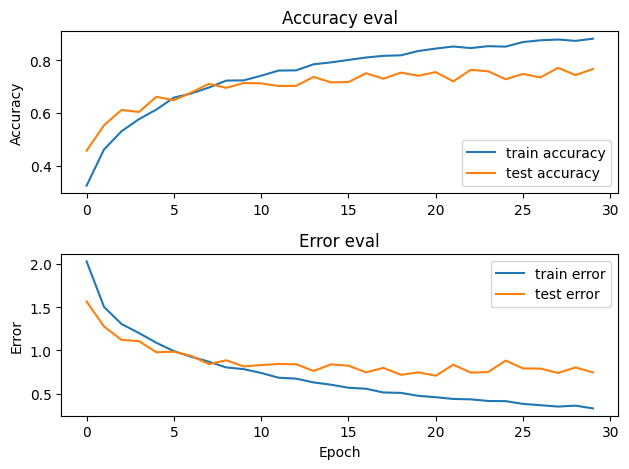

In [17]:
plot_history(history)

In [18]:
test_error, test_accuracy = cnn_model.evaluate(X_test, y_test, verbose=1)
print(f"test_accuarcy: {test_accuracy}")

63/63 [==============================] - 2s 28ms/step - loss: 0.7706 - accuracy: 0.7533
test_accuarcy: 0.7532532811164856


# Prediction using the CNN model

In [19]:
def predict(model, X, y):
    X = X[np.newaxis, ...]

    prediction = model.predict(X)  # X -> (130, 13, 1) requires -> (1, 130, 13 ,1)
    prediction_index = np.argmax(prediction, axis=1)
    print(f"Expected index: {y}\n Predicted index:{prediction_index}")

In [20]:
X = X_test[100]
y = y_test[100]
predict(cnn_model, X, y)
X = X_test[196]
y = y_test[196]
predict(cnn_model, X, y)
X = X_test[109]
y = y_test[109]
predict(cnn_model, X, y)

1/1 [==============================] - 0s 22ms/step
Expected index: 4
 Predicted index:[4]
1/1 [==============================] - 0s 22ms/step
Expected index: 3
 Predicted index:[3]
1/1 [==============================] - 0s 22ms/step
Expected index: 6
 Predicted index:[6]
